In [2]:
# 1. Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO

In [3]:
# 2. Define paths
base_run_folder = "runs/obb/boat_obb_v1"
analyse_folder = os.path.join(base_run_folder, "analyse")
os.makedirs(analyse_folder, exist_ok=True)  # create if doesn't exist


model_path = os.path.join(base_run_folder, "weights", "best.pt")
data_yaml = "data/dataset.yaml"  # adjust if your dataset path is different

In [4]:
# 3. Load YOLO model
model = YOLO(model_path)

In [5]:
# 4. Run validation on test split
metrics = model.val(data=data_yaml, split="test", plots=False)


Ultralytics 8.4.1 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA GeForce RTX 4080, 15937MiB)
YOLO26s-obb summary (fused): 132 layers, 9,753,489 parameters, 0 gradients, 21.5 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9543.4±830.7 MB/s, size: 1559.1 KB)
val: Scanning /home/thomas/Documents/thomas/HighRes-GeoSpatial-Annotation/yolo/data/processed/labels/test.cache... 58 images, 5 backgrounds, 3 corrupt: 100% ━━━━━━━━━━━━ 58/58 27.0Mit/s 0.0s
val: /home/thomas/Documents/thomas/HighRes-GeoSpatial-Annotation/yolo/data/processed/images/test/IMG_PNEO3_STD_202304300656161_MS-FS_ORT_PWOI_000373589_4_1_F_1_R1C2_3840_13440.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.026223]
val: /home/thomas/Documents/thomas/HighRes-GeoSpatial-Annotation/yolo/data/processed/images/test/IMG_PNEO3_STD_202405300711567_PAN_ORT_PWOI_000373512_3_1_F_1_P_R2C1_10560_9600.png: ignoring corrupt image/label: non-normalized or out of bounds coordinates [1.015596]
val: /

In [10]:
# 5. Extract dynamic curves and the fixed mAP50 score
p_curve = metrics.box.p_curve.mean(axis=0)
r_curve = metrics.box.r_curve.mean(axis=0)
f1_curve = metrics.box.f1_curve.mean(axis=0)

# Extract the overall scalar mAP50 score
map50_score = metrics.box.map50

# YOLO evaluates exactly 1000 confidence thresholds evenly spaced
conf_thresholds = np.linspace(0, 1, 1000)

Saved plot to: runs/obb/boat_obb_v1/analyse/confidence_vs_metrics.png


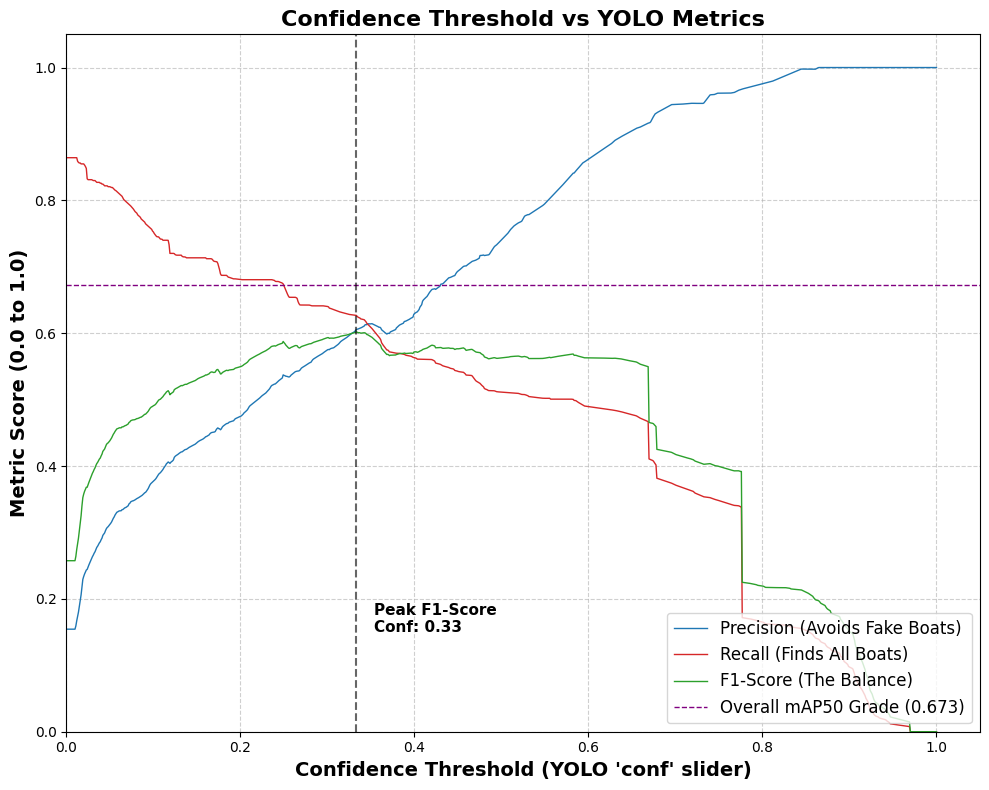

In [25]:
# 6. Plotting: Confidence vs Metric Curves
plt.figure(figsize=(10, 8))

# The dynamic curves
plt.plot(conf_thresholds, p_curve, label="Precision (Avoids Fake Boats)", color="#1f77b4", linewidth=1)
plt.plot(conf_thresholds, r_curve, label="Recall (Finds All Boats)", color="#d62728", linewidth=1)
plt.plot(conf_thresholds, f1_curve, label="F1-Score (The Balance)", color="#2ca02c", linewidth=1)

# The static mAP50 baseline
plt.axhline(y=map50_score, color="purple", linestyle="--", linewidth=1, 
            label=f"Overall mAP50 Grade ({map50_score:.3f})")

# Highlight peak F1
best_f1_idx = np.argmax(f1_curve)
best_conf = conf_thresholds[best_f1_idx]
plt.axvline(x=best_conf, color="black", linestyle="--", alpha=0.6)
plt.text(best_conf + 0.02, 0.15, f"Peak F1-Score\nConf: {best_conf:.2f}", fontsize=11, weight='bold')

# Formatting
plt.title("Confidence Threshold vs YOLO Metrics", fontsize=16, weight='bold')
plt.xlabel("Confidence Threshold (YOLO 'conf' slider)", fontsize=14, weight='bold')
plt.ylabel("Metric Score (0.0 to 1.0)", fontsize=14, weight='bold')
plt.xlim(0, 1.05)
plt.ylim(0, 1.05)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(loc="lower right", fontsize=12)
plt.tight_layout()

# Save figure
plot_path = os.path.join(analyse_folder, "confidence_vs_metrics.png")
plt.savefig(plot_path)
print(f"Saved plot to: {plot_path}")

plt.show()